### Imports
Import packages and load model parameters (uncertainties, levers, etc.)

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle

In [2]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.4.2
2.8.3


In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation


def sum_over(*args):
    return sum(args)

In [4]:
# Enable logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

**Problem formulation**
Important cell below, here you can choose the problem formulation number, between 0-5
each problem formulation has its own list of outcomes

In [5]:
used_problem_formulation = 3

dike_model, planning_steps = get_model_for_problem_formulation(used_problem_formulation)

In [6]:
# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

#for unc in dike_model.uncertainties:
#    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

In [7]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
#for policy in dike_model.levers:
#    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

In [8]:
# enlisting outcomes
#for outcome in dike_model.outcomes:
#    print(repr(outcome))

### Policy formulations
In the following cells the wanted policies can be adjusted

In [9]:
# Create a function which sets everything to 0 by default
def get_0_dict():
    return {l.name: 0 for l in dike_model.levers}

# Creates a Policy object from a dict and a (optional) name
def create_policy(dict1, name=None):
    return Policy(f"Policy_{name}", **dict(get_0_dict(), **dict1))

In [10]:
print(get_0_dict())

{'0_RfR 0': 0, '0_RfR 1': 0, '0_RfR 2': 0, '1_RfR 0': 0, '1_RfR 1': 0, '1_RfR 2': 0, '2_RfR 0': 0, '2_RfR 1': 0, '2_RfR 2': 0, '3_RfR 0': 0, '3_RfR 1': 0, '3_RfR 2': 0, '4_RfR 0': 0, '4_RfR 1': 0, '4_RfR 2': 0, 'EWS_DaysToThreat': 0, 'A.1_DikeIncrease 0': 0, 'A.1_DikeIncrease 1': 0, 'A.1_DikeIncrease 2': 0, 'A.2_DikeIncrease 0': 0, 'A.2_DikeIncrease 1': 0, 'A.2_DikeIncrease 2': 0, 'A.3_DikeIncrease 0': 0, 'A.3_DikeIncrease 1': 0, 'A.3_DikeIncrease 2': 0, 'A.4_DikeIncrease 0': 0, 'A.4_DikeIncrease 1': 0, 'A.4_DikeIncrease 2': 0, 'A.5_DikeIncrease 0': 0, 'A.5_DikeIncrease 1': 0, 'A.5_DikeIncrease 2': 0}


In the following policies formulations:
- `RfR` says if the Room for River projects are enabled (projects `0` to `5`). The first number indicated the project, the second (after `RfR`) if in which time step the measure it taken (currently `0` to `2`). The value can be either `0` (not enabled) or `1` (enabled).
- `A.1` to `A.5` are the different dikes. `A.3` is the dike ring around Zutphen. The number after `DikeIncrease` is again the timestep, the value assigned to the thing the heightening in decimeters.
- Early Warning Systems can also be enabled, with `EWS_DaysToThreat`, which specifies the early warning time in days.

See the implementation in problem_formulation.py (starting from line 35) for more details.

In [11]:
# Create an empty list with policies
pol_list = []

# Add the Zero policy
pol_list.append(create_policy({}, name="Zero"))

# Add the policy that Rijkswaterstaat proposed
pol_list.append(create_policy({"A.3_DikeIncrease 0": 10, "A.5_DikeIncrease 0": 10, "1_RfR 0": 1, "2_RfR 0": 1, "4_RfR 0": 1, "EWS_DaysToThreat": 4}, name=f"Rijkswaterstaat"))

# Add the policy Rijkswaterstaat proposed, but with also RfR in A.3
pol_list.append(create_policy({"A.3_DikeIncrease 0": 10, "A.5_DikeIncrease 0": 10, "1_RfR 0": 1, "2_RfR 0": 1, "3_RfR 0": 1, "4_RfR 0": 1, "EWS_DaysToThreat": 4}, name=f"Rijkswaterstaat+A.3RfR"))

### Run the model (or load the data)
In the next cell the model is ran (if `use_pickle1 = False`) and the new results data is saved, or, if `use_pickle1 = True`, the saved results data is loaded.

In [12]:
# True, use results in pickle file; False, run MultiprocessingEvaluator
use_pickle1 = True

if use_pickle1:
    with open('data/rijkswaterstaat_results.pickle', 'rb') as filehandler:
        results = pickle.load(filehandler)

else:
    # pass the policies list to EMA workbench experiment runs
    n_scenarios = 125
    with MultiprocessingEvaluator(dike_model, n_processes=3) as evaluator:
        results = evaluator.perform_experiments(n_scenarios, pol_list)

    # Save results in Pickle file
    with open('data/rijkswaterstaat_results.pickle', 'wb') as filehandler:
        pickle.dump(results, filehandler)

[MainProcess/INFO] pool started with 3 workers
[MainProcess/INFO] performing 125 scenarios * 3 policies * 1 model(s) = 375 experiments
100%|████████████████████████████████████████| 375/375 [01:14<00:00,  5.01it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


### Process the results
In this section a dataframe is generated with all the outcomes data, and aggegrated to mean, min, max and quantiles values for each policy.

In [13]:
# Create a dataframe from outcomes, and add the policy column to it
exp, out = results
df = pd.DataFrame(out)
df["policy"] = pd.DataFrame(exp)["policy"]
df.head()

,A.1 Total Costs,A.1_Expected Number of Deaths,A.2 Total Costs,A.2_Expected Number of Deaths,A.3 Total Costs,A.3_Expected Number of Deaths,A.4 Total Costs,A.4_Expected Number of Deaths,A.5 Total Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,policy
0,2.311799e+09,1.965783,4.294919e+07,0.050925,7.843559e+07,0.178013,0.000000,0.000000,8.620930e+07,0.098701,0.0,0.0,Policy_Zero
1,0.000000e+00,0.000000,3.488069e+08,0.332611,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,Policy_Zero
2,0.000000e+00,0.000000,5.878938e+07,0.055093,2.141872e+09,3.520135,0.000000,0.000000,6.567188e+07,0.056895,0.0,0.0,Policy_Zero
3,1.307905e+07,0.008918,2.163956e+07,0.019865,2.241495e+09,3.509883,325756.348357,0.000147,0.000000e+00,0.000000,0.0,0.0,Policy_Zero
4,4.169568e+08,0.347407,0.000000e+00,0.000000,5.843887e+08,1.220147,800765.101033,0.000446,0.000000e+00,0.000000,0.0,0.0,Policy_Zero


In [14]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [15]:
# Create a Pandas GroupBy object
group_df = df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create a dictionary with what outcome values are aggegrated with which functions
agg_dict = {
    "A.3 Total Costs": agg_par,
    "A.3_Expected Number of Deaths": agg_par,
    "RfR Total Costs": agg_par,
    "Expected Evacuation Costs": agg_par,
}
# Create new dataframe with the aggegrated data per policy
rws_df = group_df.agg(agg_dict)
rws_df

A.3 Total Costs                              \
                                         mean           min           max   
policy                                                                      
Policy_Rijkswaterstaat           4.421502e+07  4.421502e+07  4.421502e+07   
Policy_Rijkswaterstaat+A.3RfR    4.421502e+07  4.421502e+07  4.421502e+07   
Policy_Zero                      4.624819e+08  0.000000e+00  2.390040e+09   

                                                           \
                                        q05           q95   
policy                                                      
Policy_Rijkswaterstaat         4.421502e+07  4.421502e+07   
Policy_Rijkswaterstaat+A.3RfR  4.421502e+07  4.421502e+07   
Policy_Zero                    0.000000e+00  2.150191e+09   

                              A.3_Expected Number of Deaths                 \
                                                       mean  min       max   
policy                                                                       
Policy_Rijkswaterstaat                             0.000000  0.0  0.000000   
Policy_Rijkswaterstaat+A.3RfR                      0.000000  0.0  0.000000   
Policy_Zero                                        0.810968  0.0  3.610309   

                                             RfR Total Costs               \
                               q05       q95            mean          min   
policy                                                                      
Policy_Rijkswaterstaat         0.0  0.000000     504600000.0  504600000.0   
Policy_Rijkswaterstaat+A.3RfR  0.0  0.000000     625800000.0  625800000.0   
Policy_Zero                    0.0  3.542109             0.0          0.0   

                                                                      \
                                       max          q05          q95   
policy                                                                 
Policy_Rijkswaterstaat         504600000.0  504600000.0  504600000.0   
Policy_Rijkswaterstaat+A.3RfR  625800000.0  625800000.0  625800000.0   
Policy_Zero                            0.0          0.0          0.0   

                              Expected Evacuation Costs              \
                                                   mean         min   
policy                                                                
Policy_Rijkswaterstaat                     18753.520528  510.421598   
Policy_Rijkswaterstaat+A.3RfR              17059.185659  321.042042   
Policy_Zero                                    0.000000    0.000000   

                                                                        
                                        max          q05           q95  
policy                                                                  
Policy_Rijkswaterstaat         83918.774535  1268.099422  67051.775583  
Policy_Rijkswaterstaat+A.3RfR  83374.235095  1044.495206  64806.824090  
Policy_Zero                        0.000000     0.000000      0.000000

In [16]:
# Save the aggegrated data to a CSV file
rws_df.to_csv(f"results/rijkswaterstaat_policies.csv")

In [17]:
rws_df.columns.names

FrozenList([None, None])

### Plots

TODO: Make make some nice Seaborn plots?

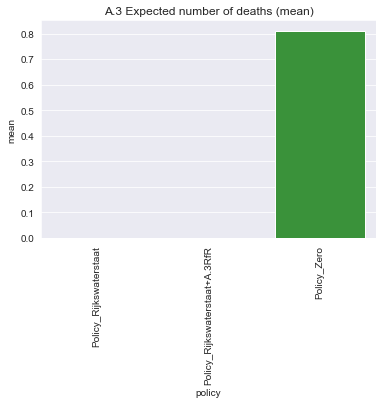

<Figure size 432x288 with 0 Axes>

In [18]:
#rws_df["Expected Number of Deaths"]["mean"].plot.bar()
ND = sns.barplot(x= rws_df.index , y = rws_df["A.3_Expected Number of Deaths"]["mean"], data = rws_df)
ND.set(title='A.3 Expected number of deaths (mean)')
#ND.fig.suptitle('Expected number of deaths')
plt.xticks(rotation=90)
plt.show()
plt.savefig('images/RWS_A3_number_of_deaths.png')

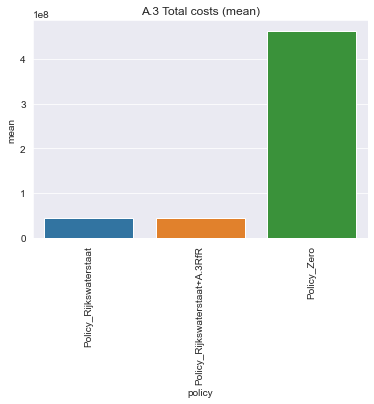

<Figure size 432x288 with 0 Axes>

In [19]:
#rws_df["Total Costs"]["mean"].plot.bar()
TC = sns.barplot(x= rws_df.index , y = rws_df["A.3 Total Costs"]["mean"], data = rws_df)
TC.set(title='A.3 Total costs (mean)')
plt.xticks(rotation=90)
plt.show()
plt.savefig('images/RWS_A3_total_costs.png')